In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
from PIL import Image
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import joblib
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

In [31]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
CSV_PATH = '/content/drive/My Drive/fake_job_postings.csv'
IMG_ROOT = '/content/drive/My Drive/images'
TEXTCAT_MODEL_PATH = "/content/drive/MyDrive/multimodal_model.pt"
IMG_MODEL_PATH = "/content/drive/MyDrive/image_model_weights.weights.h5"
BERT_MODEL_NAME = "bert-base-uncased"
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train_df = pd.read_csv(CSV_PATH)
print("Rows:", len(train_df))

Rows: 17880


In [6]:
text_emb = torch.load("/content/drive/MyDrive/bert_embeddings.pt", map_location=DEVICE)

In [11]:
class TextCatModel(nn.Module):
    def __init__(self, structured_dim):
        super().__init__()
        self.fc1 = nn.Linear(768 + structured_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [7]:
categorical_features = ["employment_type", "required_experience", "required_education", "industry", "function"]
le = LabelEncoder()
train_df["employment_type_encoded"] = le.fit_transform(train_df["employment_type"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)
train_df["required_experience_encoded"] = le.fit_transform(train_df["required_experience"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)
train_df["required_education_encoded"] = le.fit_transform(train_df["required_education"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)
train_df["industry_encoded"] = le.fit_transform(train_df["industry"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)
train_df["function_encoded"] = le.fit_transform(train_df["function"].astype(str)) + 1
mapping = {cls: code+1 for cls, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'Contract': np.int64(1), 'Full-time': np.int64(2), 'Other': np.int64(3), 'Part-time': np.int64(4), 'Temporary': np.int64(5), 'nan': np.int64(6)}
{'Associate': np.int64(1), 'Director': np.int64(2), 'Entry level': np.int64(3), 'Executive': np.int64(4), 'Internship': np.int64(5), 'Mid-Senior level': np.int64(6), 'Not Applicable': np.int64(7), 'nan': np.int64(8)}
{'Associate Degree': np.int64(1), "Bachelor's Degree": np.int64(2), 'Certification': np.int64(3), 'Doctorate': np.int64(4), 'High School or equivalent': np.int64(5), "Master's Degree": np.int64(6), 'Professional': np.int64(7), 'Some College Coursework Completed': np.int64(8), 'Some High School Coursework': np.int64(9), 'Unspecified': np.int64(10), 'Vocational': np.int64(11), 'Vocational - Degree': np.int64(12), 'Vocational - HS Diploma': np.int64(13), 'nan': np.int64(14)}
{'Accounting': np.int64(1), 'Airlines/Aviation': np.int64(2), 'Alternative Dispute Resolution': np.int64(3), 'Animation': np.int64(4), 'Apparel & Fashion': np.i

In [8]:
def parse_salary(s):
    if pd.isna(s):
        return np.nan, np.nan
    s = s.replace(',', '').replace('$', '').lower()
    s = s.replace('k', '000')
    nums = re.findall(r'\d+', s)
    if len(nums) == 1:
        return float(nums[0]), float(nums[0])
    elif len(nums) >= 2:
        return float(nums[0]), float(nums[1])
    else:
        return np.nan, np.nan

train_df[['salary_min', 'salary_max']] = train_df['salary_range'].apply(lambda x: pd.Series(parse_salary(x)))
train_df['salary_mean'] = train_df[['salary_min', 'salary_max']].mean(axis=1)

bins = [0, 30000, 60000, 100000, 200000, np.inf]
labels = [1, 2, 3, 4, 5]


train_df['salary_category'] = pd.cut(train_df['salary_mean'], bins=bins, labels=labels)
train_df['salary_category'] = train_df['salary_category'].cat.add_categories([0])
train_df['salary_category'] = train_df['salary_category'].fillna(0).astype(int)
train_df = train_df.drop('salary_range', axis=1)


In [9]:
X_struct = train_df.drop(columns=['fraudulent','title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits','employment_type', 'required_experience', 'required_education', 'industry', 'function'])
X_struct['salary_missing'] = X_struct['salary_mean'].isnull().astype(int)
X_struct[['salary_min', 'salary_max', 'salary_mean']] = X_struct[['salary_min', 'salary_max', 'salary_mean']].fillna(0).values.astype(np.float32)
X_struct = X_struct[
    ['telecommuting', 'has_company_logo', 'has_questions',
     'employment_type_encoded', 'required_experience_encoded',
     'required_education_encoded', 'function_encoded',
     'salary_category', 'salary_missing']
]
X_struct = X_struct.astype(np.float32).values

In [12]:
textcat_input = np.concatenate([
    text_emb.cpu().numpy(),
    X_struct
], axis=1)

textcat_input_tensor = torch.tensor(textcat_input, dtype=torch.float32).to(DEVICE)

In [13]:
structured_dim = X_struct.shape[1]
textcat_model = TextCatModel(structured_dim=structured_dim).to(DEVICE)

state = torch.load(TEXTCAT_MODEL_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']

textcat_model.load_state_dict(state)
textcat_model.eval()


TextCatModel(
  (fc1): Linear(in_features=777, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
img_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
img_model.load_weights(IMG_MODEL_PATH)

In [ ]:
img_feats = []
has_img_mask = []

for i, row in train_df.iterrows():
    if row['has_company_logo'] == 1:
        img_path = os.path.join(IMG_ROOT, f"{row['job_id']}.png")
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((224,224))
            img_array = np.array(img)[np.newaxis, ...]
            img_array = preprocess_input(img_array)
            feat = img_model.predict(img_array)
            img_feats.append(feat[0])
            has_img_mask.append(1)
        else:
            img_feats.append(np.zeros(img_model.output_shape[1]))
            has_img_mask.append(0)
    else:
        img_feats.append(np.zeros(img_model.output_shape[1]))
        has_img_mask.append(0)

# Convert to tensors
img_feats_tensor = torch.tensor(np.vstack(img_feats), dtype=torch.float32).to(DEVICE)
has_img_mask_tensor = torch.tensor(has_img_mask, dtype=torch.float32).to(DEVICE)


In [ ]:
torch.save(img_feats_tensor, "/content/drive/MyDrive/img_feats.pt")
torch.save(has_img_mask_tensor, "/content/drive/MyDrive/has_img_mask.pt")

In [42]:
img_feats_tensor = torch.load("/content/drive/MyDrive/img_feats.pt").to(DEVICE) #map_location=torch.device('cpu')
has_img_mask_tensor = torch.load("/content/drive/MyDrive/has_img_mask.pt").to(DEVICE) #map_location=torch.device('cpu')

# **Decision-level Fusion Head**

In [17]:
class FusionHead(nn.Module):
    def __init__(self, text_dim, img_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(text_dim + img_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text_feat, img_feat):
        x = torch.cat([text_feat, img_feat], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [18]:
class FusionDataset(Dataset):
    def __init__(self, text_feat, img_feat, has_img_mask, labels):
        self.text_feat = text_feat
        self.img_feat = img_feat
        self.has_img_mask = has_img_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        t = self.text_feat[idx]
        i = self.img_feat[idx] if self.has_img_mask[idx] else torch.zeros_like(self.img_feat[idx])
        y = self.labels[idx]
        return t, i, y

In [19]:
text_feat = textcat_input_tensor

In [20]:
has_img_mask_tensor = (has_img_mask_tensor > 0).to(torch.bool)

In [21]:
y_tensor = torch.tensor(train_df['fraudulent'].values, dtype=torch.float32).to(DEVICE)

In [22]:
X_tr_idx, X_val_idx = train_test_split(
    np.arange(len(y_tensor)), test_size=0.2, stratify=train_df['fraudulent'], random_state=42
)

In [23]:
train_dataset = FusionDataset(text_feat[X_tr_idx], img_feats_tensor[X_tr_idx], has_img_mask_tensor[X_tr_idx], y_tensor[X_tr_idx])
val_dataset = FusionDataset(text_feat[X_val_idx], img_feats_tensor[X_val_idx], has_img_mask_tensor[X_val_idx], y_tensor[X_val_idx])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [24]:
text_dim = text_feat.shape[1]
img_dim = img_feats_tensor.shape[1]

fusion_model = FusionHead(text_dim=text_dim, img_dim=img_dim, hidden_dim=128).to(DEVICE)

In [25]:
pos_weight = torch.tensor([(len(y_tensor)-y_tensor.sum())/y_tensor.sum()]).to(DEVICE)
criterion = nn.BCELoss(weight=pos_weight)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

num_epochs = 10

for epoch in range(num_epochs):
    fusion_model.train()
    total_loss = 0
    for t_feat, i_feat, labels in train_loader:
        t_feat, i_feat, labels = t_feat.to(DEVICE), i_feat.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        preds = fusion_model(t_feat, i_feat)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * t_feat.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    fusion_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for t_feat, i_feat, labels in val_loader:
            t_feat, i_feat, labels = t_feat.to(DEVICE), i_feat.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            preds = fusion_model(t_feat, i_feat)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    all_preds_np = all_preds_tensor.numpy()
    all_labels_np = all_labels_tensor.numpy()
    all_preds_bin = (all_preds_np > 0.5).astype(int)

    acc = accuracy_score(all_labels_np, all_preds_bin)
    prec = precision_score(all_labels_np, all_preds_bin, zero_division=0)
    rec = recall_score(all_labels_np, all_preds_bin, zero_division=0)
    f1 = f1_score(all_labels_np, all_preds_bin, zero_division=0)
    auc = roc_auc_score(all_labels_np, all_preds_np)

    print(f"Epoch {epoch+1}/{num_epochs} Loss={avg_loss:.4f} "
          f"AUC={auc:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")


Epoch 1/10 Loss=0.4444 AUC=0.9813 Acc=0.9855 Prec=0.8538 Rec=0.8439 F1=0.8488
Epoch 2/10 Loss=0.3578 AUC=0.9827 Acc=0.9866 Prec=0.8743 Rec=0.8439 F1=0.8588
Epoch 3/10 Loss=0.3090 AUC=0.9826 Acc=0.9852 Prec=0.8488 Rec=0.8439 F1=0.8464
Epoch 4/10 Loss=0.3119 AUC=0.9818 Acc=0.9852 Prec=0.8571 Rec=0.8324 F1=0.8446
Epoch 5/10 Loss=0.2957 AUC=0.9824 Acc=0.9852 Prec=0.8488 Rec=0.8439 F1=0.8464
Epoch 6/10 Loss=0.2781 AUC=0.9833 Acc=0.9866 Prec=0.8743 Rec=0.8439 F1=0.8588
Epoch 7/10 Loss=0.2900 AUC=0.9838 Acc=0.9849 Prec=0.8439 Rec=0.8439 F1=0.8439
Epoch 8/10 Loss=0.2761 AUC=0.9833 Acc=0.9860 Prec=0.8639 Rec=0.8439 F1=0.8538
Epoch 9/10 Loss=0.2621 AUC=0.9801 Acc=0.9855 Prec=0.8580 Rec=0.8382 F1=0.8480
Epoch 10/10 Loss=0.2608 AUC=0.9834 Acc=0.9852 Prec=0.8659 Rec=0.8208 F1=0.8427


In [32]:
fusion_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for t_feat, i_feat, labels in val_loader:
        t_feat, i_feat, labels = t_feat.to(DEVICE), i_feat.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        preds = fusion_model(t_feat, i_feat)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds_tensor = torch.cat(all_preds, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

all_preds_np = all_preds_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()
all_preds_bin = (all_preds_np > 0.5).astype(int)

final_acc = accuracy_score(all_labels_np, all_preds_bin)
final_prec = precision_score(all_labels_np, all_preds_bin, zero_division=0)
final_rec = recall_score(all_labels_np, all_preds_bin, zero_division=0)
final_f1 = f1_score(all_labels_np, all_preds_bin, zero_division=0)
final_auc = roc_auc_score(all_labels_np, all_preds_np)

print("\nFinal Validation Metrics After Training:")
print(f"AUC-ROC: {final_auc:.4f}")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_prec:.4f}")
print(f"Recall: {final_rec:.4f}")
print(f"F1 Score: {final_f1:.4f}")


Final Validation Metrics After Training:
AUC-ROC: 0.9834
Accuracy: 0.9852
Precision: 0.8659
Recall: 0.8208
F1 Score: 0.8427


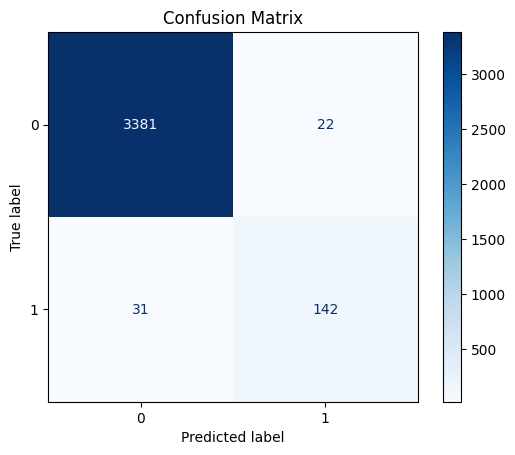

In [33]:
cm = confusion_matrix(all_labels_np, all_preds_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


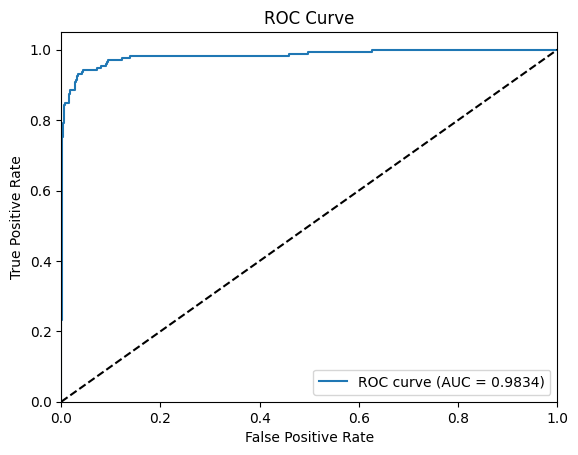

In [36]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(all_labels_np, all_preds_np)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [37]:
torch.save(fusion_model, "/content/drive/MyDrive/fusion_head_full_model.pt")

In [ ]:
fusion_model = torch.load("/content/drive/MyDrive/fusion_head_full_model.pt")
fusion_model.eval()

In [38]:
torch.save(fusion_model.state_dict(), "/content/drive/MyDrive/fusion_head_state_dict.pt")

# **Feature-level Fusion**

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [40]:
X_struct_tensor = torch.tensor(X_struct, dtype=torch.float32).to(DEVICE)
labels_tensor = torch.tensor(train_df['fraudulent'].values, dtype=torch.float32).to(DEVICE)

In [43]:
# Mask image features for rows without images
img_feats_masked = img_feats_tensor.clone()
img_feats_masked[has_img_mask_tensor == 0] = 0.0

# Concatenate features for fusion
fused_features = torch.cat([text_emb, X_struct_tensor, img_feats_masked], dim=1)

In [44]:
fused_features_np = fused_features.cpu().numpy()
labels_np = labels_tensor.cpu().numpy()

In [45]:
from sklearn.model_selection import train_test_split

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    fused_features_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np
)

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(DEVICE)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(DEVICE)

In [46]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [47]:
# ----- 3. Define Fusion Model -----
class FeatureLevelFusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_dim = fused_features.shape[1]
fusion_model = FeatureLevelFusionModel(input_dim).to(DEVICE)

In [48]:
# ----- 4. Weighted loss for class imbalance -----
# Compute class weights
num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()
pos_weight_scalar = num_neg / num_pos
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_scalar]).to(DEVICE))

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)

In [50]:
best_auc = 0.0
best_model_path = "/content/drive/MyDrive/feature_fusion_full_model.pt"

num_epochs = 10
for epoch in range(num_epochs):
    fusion_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(1).float()
        optimizer.zero_grad()
        preds = fusion_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # Validation
    fusion_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(1).float()
            preds = fusion_model(X_batch)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    preds_np = all_preds.numpy()
    labels_np = all_labels.numpy()

    preds_bin = (preds_np > 0.5).astype(int)

    acc = accuracy_score(labels_np, preds_bin)
    prec = precision_score(labels_np, preds_bin, zero_division=0)
    rec = recall_score(labels_np, preds_bin, zero_division=0)
    f1 = f1_score(labels_np, preds_bin, zero_division=0)
    auc = roc_auc_score(labels_np, preds_np)

    print(f"Epoch {epoch+1}/{num_epochs} Loss={avg_loss:.4f} "
          f"AUC={auc:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")

    # -------- SAVE BEST MODEL --------
    if auc > best_auc:
        best_auc = auc
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": fusion_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_auc": best_auc
        }, best_model_path)
        print(f"Saved best model (AUC={best_auc:.4f})")


Epoch 1/10 Loss=0.1073 AUC=0.9842 Acc=0.9815 Prec=0.7831 Rec=0.8555 F1=0.8177
Saved best model (AUC=0.9842)
Epoch 2/10 Loss=0.0775 AUC=0.9837 Acc=0.9813 Prec=0.7760 Rec=0.8613 F1=0.8164
Epoch 3/10 Loss=0.0669 AUC=0.9832 Acc=0.9804 Prec=0.7696 Rec=0.8497 F1=0.8077
Epoch 4/10 Loss=0.0752 AUC=0.9824 Acc=0.9793 Prec=0.7438 Rec=0.8728 F1=0.8032
Epoch 5/10 Loss=0.0698 AUC=0.9834 Acc=0.9787 Prec=0.7413 Rec=0.8613 F1=0.7968
Epoch 6/10 Loss=0.0513 AUC=0.9835 Acc=0.9807 Prec=0.7680 Rec=0.8613 F1=0.8120
Epoch 7/10 Loss=0.0675 AUC=0.9817 Acc=0.9776 Prec=0.7225 Rec=0.8728 F1=0.7906
Epoch 8/10 Loss=0.0563 AUC=0.9813 Acc=0.9804 Prec=0.7588 Rec=0.8728 F1=0.8118
Epoch 9/10 Loss=0.0578 AUC=0.9827 Acc=0.9801 Prec=0.7629 Rec=0.8555 F1=0.8065
Epoch 10/10 Loss=0.0660 AUC=0.9821 Acc=0.9740 Prec=0.6754 Rec=0.8902 F1=0.7681



Final Validation Metrics:
AUC-ROC: 0.9821
Accuracy: 0.9740
Precision: 0.6754
Recall: 0.8902
F1 Score: 0.7681


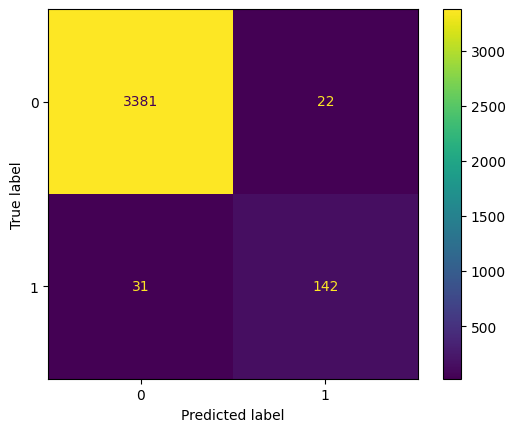

In [51]:
# ----- 6. Final validation metrics -----
print(f"\nFinal Validation Metrics:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Confusion Matrix
cm = confusion_matrix(all_labels_np, all_preds_bin)
ConfusionMatrixDisplay(cm).plot()

# **Conditional Fusion Model : End-to-end Pipeline**

In [36]:
import os
import random
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
CSV_PATH = '/content/drive/My Drive/fake_job_postings.csv'
IMG_ROOT = '/content/drive/My Drive/images'
TEXTCAT_MODEL_PATH = "/content/drive/MyDrive/multimodal_model.pt"
IMG_MODEL_PATH = "/content/drive/MyDrive/image_model_weights.weights.h5"
BERT_MODEL_NAME = "bert-base-uncased"
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:

# --------------------- 1. Load CSV --------------------

df = pd.read_csv(CSV_PATH)
df.fillna("", inplace=True)
df["text"] = (
    df["title"].astype(str) + " " +
    df["location"].astype(str) + " " +
    df["department"].astype(str) + " " +
    df["company_profile"].astype(str) + " " +
    df["description"].astype(str) + " " +
    df["requirements"].astype(str) + " " +
    df["benefits"].astype(str)
)
df["label"] = df["fraudulent"].astype(int)

In [16]:

# --------------------- 2. Categorical preprocessing ---------------------
categorical_features = ["employment_type", "required_experience", "required_education", "industry", "function"]
for col in categorical_features:
    le = LabelEncoder()
    df[col+"_encoded"] = le.fit_transform(df[col].astype(str)) + 1

# Salary parsing
def parse_salary(s):
    if pd.isna(s):
        return np.nan, np.nan
    s = s.replace(',', '').replace('$', '').lower().replace('k','000')
    nums = re.findall(r'\d+', s)
    if len(nums) == 1:
        return float(nums[0]), float(nums[0])
    elif len(nums) >= 2:
        return float(nums[0]), float(nums[1])
    else:
        return np.nan, np.nan
df[['salary_min', 'salary_max']] = df['salary_range'].apply(lambda x: pd.Series(parse_salary(x)))
df['salary_mean'] = df[['salary_min', 'salary_max']].mean(axis=1)
bins = [0, 30000, 60000, 100000, 200000, np.inf]
labels = [1, 2, 3, 4, 5]
df['salary_category'] = pd.cut(df['salary_mean'], bins=bins, labels=labels)
df['salary_category'] = df['salary_category'].cat.add_categories([0]).fillna(0).astype(int)

X_struct = df[[
    'telecommuting', 'has_company_logo', 'has_questions',
    'employment_type_encoded', 'required_experience_encoded',
    'required_education_encoded', 'function_encoded',
    'salary_category'
]].astype(np.float32).values

In [17]:


# --------------------- 3. Dataset Class ---------------------
class MultiModalDataset(Dataset):
    def __init__(self, df, struct_features, tokenizer, max_len=128, img_root=IMG_ROOT):
        self.df = df.reset_index(drop=True)
        self.struct_features = struct_features
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.img_root = img_root
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.img_dim = 2048  # for ResNet50 pooled features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # -------- Text processing (BERT) --------
        encoding = self.tokenizer(
            str(row["text"]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # -------- Image processing (ResNet50) --------
        if row['has_company_logo'] == 1:
            img_path = os.path.join(self.img_root, f"{row['job_id']}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img)
            else:
                img = torch.zeros(3,224,224)
            has_img = 1
        else:
            img = torch.zeros(3,224,224)
            has_img = 0

        # -------- Structured features --------
        struct_feat = torch.tensor(self.struct_features[idx], dtype=torch.float32)

        label = torch.tensor(row["label"], dtype=torch.float32)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "img_tensor": img,
            "has_img_mask": torch.tensor(has_img, dtype=torch.float32),
            "struct_feat": struct_feat,
            "label": label
        }

In [18]:
!pip install -q transformers pytorch-lightning
import pytorch_lightning as pl

In [19]:
classes = [0, 1]
num_pos = (train_df['fraudulent'] == 1).sum()
num_neg = (train_df['fraudulent'] == 0).sum()
class_weights = torch.tensor([num_neg / (num_pos + num_neg), num_pos / (num_pos + num_neg)], dtype=torch.float32)

In [22]:
class BERTClassifier(pl.LightningModule):
    def __init__(self, n_classes, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        logits = self(input_ids, attention_mask)
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        logits = self(input_ids, attention_mask)
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=True)
        return loss
    def get_pooled_embedding(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.drop(pooled_output)
        return pooled_output
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=LR)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * NUM_EPOCHS
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

MODEL_NAME = "bert-base-uncased"
from transformers import BertTokenizer
text_model = BERTClassifier(n_classes=len(classes), class_weights=class_weights)
text_model.load_state_dict(torch.load("/content/drive/MyDrive/bert_fake_job_classifier.pt", map_location=torch.device(DEVICE)))
text_model.eval()  # set to eval if you don't want to fine-tune
text_model.to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [23]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import ResNet50
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = True

# img_model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
# ])
# img_model.load_weights(IMG_MODEL_PATH)
# import torch
# import torch.nn as nn
# import torchvision.models as models

resnet_model = models.resnet50(weights=None)  # no pretrained ImageNet weights
resnet_model.fc = nn.Identity()  # remove the final FC
resnet_model.eval().to(DEVICE)

# Load the Keras-trained backbone weights saved earlier
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/resnet50_full_pytorch_weights.pth'), strict=False)

# Freeze backbone if needed
for param in resnet_model.parameters():
    param.requires_grad = False

struct_dim = X_struct.shape[1]

In [27]:
# --------------------- 5. Conditional Fusion Model ---------------------
class ConditionalFusionModel(nn.Module):
    def __init__(self, text_model, img_model, struct_dim, fusion_hidden_dim=128, img_feat_dim=2048):
        super().__init__()
        self.text_model = text_model
        self.img_model = img_model
        self.struct_dim = struct_dim
        self.img_feat_dim = img_feat_dim

        fusion_input_dim = 768 + img_feat_dim + struct_dim
        self.fusion_fc1 = nn.Linear(fusion_input_dim, fusion_hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fusion_fc2 = nn.Linear(fusion_hidden_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, struct_feat, img_tensor, has_img_mask):
        # -------- Text embedding --------
        text_out = self.text_model.get_pooled_embedding(input_ids, attention_mask)
        # -------- Image embedding --------
        img_feat = self.img_model(img_tensor)
        img_feat = torch.where(has_img_mask.unsqueeze(1)==1, img_feat, torch.zeros_like(img_feat))

        # -------- Concatenate --------
        x = torch.cat([text_out, img_feat, struct_feat], dim=1)
        x = self.relu(self.fusion_fc1(x))
        x = self.dropout(x)
        x = self.fusion_fc2(x)
        x = self.sigmoid(x)
        return x

conditional_fusion_model = ConditionalFusionModel(text_model, resnet_model, struct_dim).to(DEVICE)

In [28]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/saved_fake_job_tokenizer")

In [29]:
# # --------------------- 6. Sample 5000 rows for evaluation ---------------------
# df_eval, _ = train_test_split(df, train_size=5000, stratify=df["label"], random_state=42)
# dataset = MultiModalDataset(df_eval, X_struct, tokenizer, max_len=128, img_root=IMG_ROOT)
# val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

train_dataset = MultiModalDataset(train_df, X_struct, tokenizer, max_len=128, img_root=IMG_ROOT)
val_dataset = MultiModalDataset(val_df, X_struct, tokenizer, max_len=128, img_root=IMG_ROOT)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [31]:
# Optional Fine-tuning of Fusion Head : Only train fusion_fc1 and fusion_fc2
for param in conditional_fusion_model.text_model.parameters():
    param.requires_grad = False
for param in conditional_fusion_model.img_model.parameters():
    param.requires_grad = False
for param in conditional_fusion_model.fusion_fc1.parameters():
    param.requires_grad = True
for param in conditional_fusion_model.fusion_fc2.parameters():
    param.requires_grad = True

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    list(conditional_fusion_model.fusion_fc1.parameters()) +
    list(conditional_fusion_model.fusion_fc2.parameters()),
    lr=1e-3
)
num_epochs = 3

# -------- Add this block BEFORE starting training ----------
best_val_loss = float("inf")
best_model_path = "/content/drive/MyDrive/best_conditional_fusion_model.pt"
# -----------------------------------------------------------

conditional_fusion_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        img_tensor = batch["img_tensor"].to(DEVICE)
        struct_feat = batch["struct_feat"].to(DEVICE)
        has_img_mask = batch["has_img_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        preds = conditional_fusion_model(input_ids, attention_mask, struct_feat, img_tensor, has_img_mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)

    epoch_loss = total_loss / len(train_dataset)
    print(f"Fine-tuning Epoch {epoch+1}/{num_epochs} Loss={epoch_loss:.4f}")

    # -------------- Save best model ----------------
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(conditional_fusion_model.state_dict(), best_model_path)
        print("Saved new best model!")
    # ------------------------------------------------


Fine-tuning Epoch 1/3 Loss=0.0130
Saved new best model!
Fine-tuning Epoch 2/3 Loss=0.0133
Fine-tuning Epoch 3/3 Loss=0.0125
Saved new best model!


In [32]:
conditional_fusion_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        img_tensor = batch["img_tensor"].to(DEVICE)
        struct_feat = batch["struct_feat"].to(DEVICE)
        has_img_mask = batch["has_img_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE).unsqueeze(1)

        preds = conditional_fusion_model(input_ids, attention_mask, struct_feat, img_tensor, has_img_mask)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds_tensor = torch.cat(all_preds, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)
all_preds_np = all_preds_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()
all_preds_bin = (all_preds_np > 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels_np, all_preds_bin)
prec = precision_score(all_labels_np, all_preds_bin, zero_division=0)
rec = recall_score(all_labels_np, all_preds_bin, zero_division=0)
f1 = f1_score(all_labels_np, all_preds_bin, zero_division=0)
auc = roc_auc_score(all_labels_np, all_preds_np)

print(f"Validation Metrics:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Validation Metrics:
AUC-ROC: 0.9872
Accuracy: 0.9880
Precision: 0.9012
Recall: 0.8439
F1 Score: 0.8716


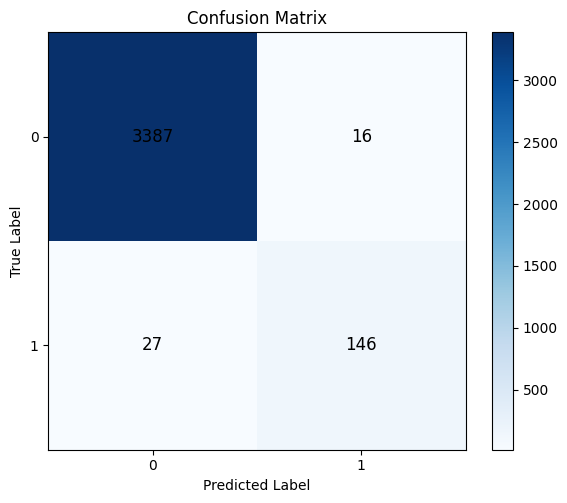

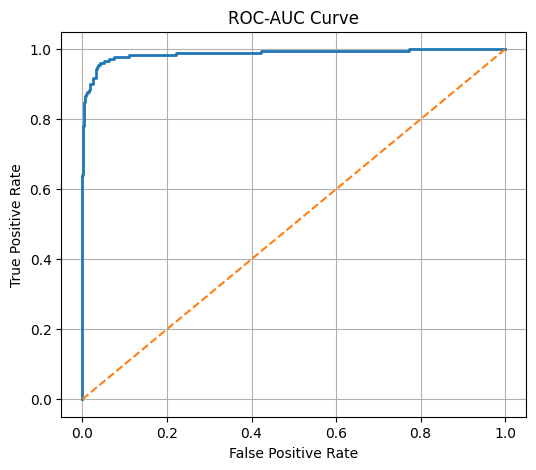

In [37]:
cm = confusion_matrix(all_labels_np, all_preds_bin)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["0", "1"])
plt.yticks(tick_marks, ["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color="black", fontsize=12)

plt.tight_layout()
plt.show()


# --------------------- ROC Curve ---------------------
fpr, tpr, thresholds = roc_curve(all_labels_np, all_preds_np)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


In [38]:
# Save the whole model
torch.save(conditional_fusion_model, '/content/drive/MyDrive/conditional_fusion_model_full.pt')


In [ ]:
# Later, to load it:
loaded_model = torch.load('/content/drive/MyDrive/conditional_fusion_model_full.pt')
loaded_model.eval()  # set to evaluation mode